# Analyzing Eluvio dataset

On a close look at the dataset, it seems to be title of posts from subreddit worldnews with upvote, downvote, username and time information. I plan to do the following things:
* Understand the data and find popular titles
* Find the popular titles based on sentiment
* Create word2vec embeddings and visualize the embeddings of most popular titles
* Predict the sentiment of a title based of sentiment values obtained using VADER
* Predict the popularity of a title based on up_vote information

In [1]:
#Author: Kaivan Shah

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

## Load the dataset into a panda dataframe

In [2]:
worldnews = pd.read_csv("Eluvio_DS_Challenge.csv")
worldnews.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


## Tokenized

Tokenize the words in the dataset (using the `nltk` `word_tokenize` built-in) and remove a bunch of redundancies -- dash, digits, punctuation, characters, concatenations -- from the result.

In [3]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

stopwords = set(stopwords.words('english'))

best_titles = worldnews.sort_values(by='up_votes', ascending=False)['title'].values[:10]
best_words = set(np.concatenate([word_tokenize(t) for t in best_titles])) - stopwords
best_words = {word.lower() for word in best_words}
best_words = best_words - set(string.punctuation) - set(string.digits)

def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

best_words = {word for word in best_words if not is_float(word)}

best_words = {word for word in best_words if "'" not in word}  # drop contractions

In [4]:
words_tokenized = [[w.lower() for w in word_tokenize(t)] for t in worldnews['title']]
worldnews['tokenized_title'] = words_tokenized
all_words = pd.Series(np.concatenate(words_tokenized)).value_counts()

In [5]:
all_words = all_words[[word not in stopwords for word in all_words.index]]
all_words = all_words[[word not in string.punctuation for word in all_words.index]]
all_words = all_words[[word not in string.digits for word in all_words.index]]
all_words = all_words[[not is_float(word) for word in all_words.index]]
all_words = all_words[["'" not in word for word in all_words.index]]

Most common words in r/worlnews title

In [6]:
all_words[1:10].index

Index(['china', 'says', 'us', 'new', 'syria', 'russia', 'world', 'police',
       'iran'],
      dtype='object')

To increase the accuracy of any models that we build let's do one more thing, let's stem our words: mapping "says" and "saying" and "said" all to "say", for example, because they are all really the same one word in different forms. We'll use the `nltk` built-in `PorterStemmer` for this.

In [7]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
all_words.index = [stemmer.stem(w) for w in all_words.index]

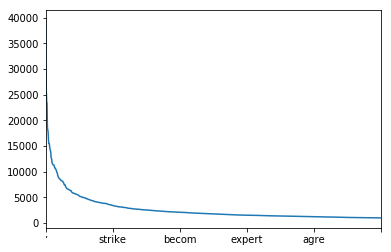

In [8]:
all_words[:1000].plot()

In [9]:
all_stems = all_words.groupby(by=all_words.index).sum().sort_values(ascending=False)
all_stems[:10].index

Index(['’', 'say', 'kill', 'china', 'us', 'new', 'attack', 'syria', 'russia',
       'world'],
      dtype='object')

In [10]:
worldnews['stemmed_title'] = worldnews['tokenized_title'].map(
    lambda wl: [stemmer.stem(w) for w in wl]
)

## Popular titles

What are the most popular topics, at least in terms of the raw number of article submitted.

What is a topic? In the context of a headline a topic isn't just any word, it's the subject of a sentence. While finding the actual subject of a sentence is hard, but in the context of this problem, I am just going to consider the proper nouns in the titles. I plan to use `nltk` `pos_tagger` built-in.

In [11]:
from nltk import pos_tag
pos_tag(worldnews['tokenized_title'][0])
worldnews['pos_title'] = worldnews['tokenized_title'].map(lambda t: [t[1] for t in pos_tag(t)])
worldnews['pos_title'].head()

0                   [NNS, VBN, IN, NN, NNS]
1                        [NN, VBZ, VBG, NN]
2                [PRP, VBZ, NN, IN, NN, NN]
3           [JJ, NN, :, JJ, NN, NN, TO, DT]
4    [NN, IN, NN, NNS, VBP, CC, JJ, NN, NN]
Name: pos_title, dtype: object

In [12]:
def topicify(srs):
    tags = srs['pos_title']
    stems = srs['stemmed_title']
    return [stem for (tag, stem) in zip(tags, stems) if tag in ['NN', 'NNS']]

In [13]:
worldnews['topics'] = worldnews.apply(topicify, axis='columns')
worldnews['topics'].head()

0                     [score, pakistan, clash]
1                             [japan, mission]
2                        [egypt, gaza, border]
3                      [economi, health, care]
4    [council, europ, bash, terror, blacklist]
Name: topics, dtype: object

In [14]:
worldnews.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,tokenized_title,stemmed_title,pos_title,topics
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,"[scores, killed, in, pakistan, clashes]","[score, kill, in, pakistan, clash]","[NNS, VBN, IN, NN, NNS]","[score, pakistan, clash]"
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,"[japan, resumes, refuelling, mission]","[japan, resum, refuel, mission]","[NN, VBZ, VBG, NN]","[japan, mission]"
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,"[us, presses, egypt, on, gaza, border]","[us, press, egypt, on, gaza, border]","[PRP, VBZ, NN, IN, NN, NN]","[egypt, gaza, border]"
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,"[jump-start, economy, :, give, health, care, t...","[jump-start, economi, :, give, health, care, t...","[JJ, NN, :, JJ, NN, NN, TO, DT]","[economi, health, care]"
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,"[council, of, europe, bashes, eu, &, un, terro...","[council, of, europ, bash, eu, &, un, terror, ...","[NN, IN, NN, NNS, VBP, CC, JJ, NN, NN]","[council, europ, bash, terror, blacklist]"


In [15]:
topic_counts = pd.Series(np.concatenate(worldnews['topics'].values)).value_counts()
topic_counts[1:].head(10)

china     21658
attack    18447
world     17997
year      16576
govern    16199
state     16054
polic     15917
syria     15902
russia    15619
presid    15262
dtype: int64

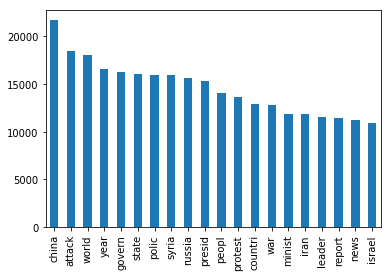

In [16]:
topic_counts[1:].head(20).plot(kind='bar')

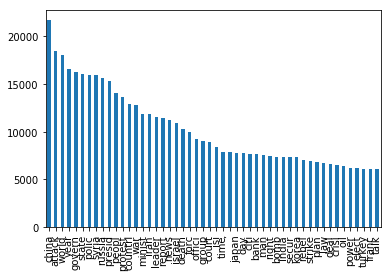

In [17]:
topic_counts[1:].head(50).plot(kind='bar')

## Popular Topics by Sentiment

Another thing that's easy to do is looking at the top topics by sentiment. To do this we can use the off-the-shelf VADER sentiment analyzer available in nltk. Unfortunately this is also a bit wonky because we are asking it to process word stems, not words, and word stems may not even be valid words!

You can fix this pretty easily yourself if you're so inclined by running the sentiment analyzer on all of the titles containing that stem and then taking the mean of the sentiment responses. I'm not too concerned about it though because I just want to get an "impressionistic" understanding of what r/worldnews obsesses over, for which what we already have is enough.

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
topics = topic_counts.sort_values(ascending=False)#.head(1000)
topic_sentiments = [sid.polarity_scores(w)['compound'] for w in topics.index]
tmp = pd.DataFrame(topics).assign(sentiment=topic_sentiments)

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


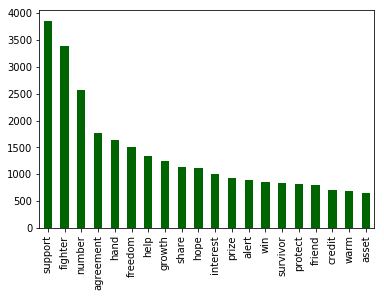

In [19]:
tmp.query('sentiment > 0').head(20)[0].plot(kind='bar', color='darkgreen')

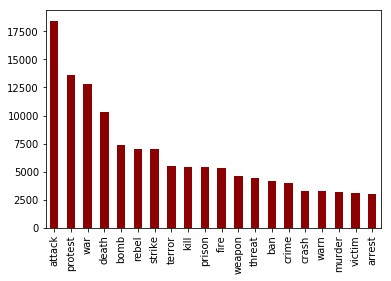

In [20]:
tmp.query('sentiment < 0').head(20)[0].plot(kind='bar', color='darkred')

# Word2Vec using gensim

Word2Vec(word to vector) model creates word vectors, known as embeddings, by looking at the context based on how they appear in the sentences. Words with similar contexts are placed closed together. The context of the words helps us determine their meanings and understand the sentiment from positive to negative. 

In [21]:
#!pip install gensim

In [22]:
from gensim.models import Word2Vec, KeyedVectors
import nltk
import multiprocessing

EMBEDDING_DIM = 100

In [23]:
newsVec = worldnews['tokenized_title']

## Create embeddings

* sentences - List of tokenized titles
* size - EMBEDDING DIM: 200
* window - only terms that occur within a window neighborhood of a term in a sentence are associated with it during training: 5
* min_count - words with frequency greater than min_count: 2
* workers - number of threads used in training parallelization, to speed up training

In [24]:
model = Word2Vec(sentences=newsVec, size=EMBEDDING_DIM, window=5, min_count=2, workers=multiprocessing.cpu_count())

## Save the word2vec model

So that it can be used in the embedding layer for sentiment classification

In [25]:
filename = "embedding_word2vec.txt"
model.wv.save_word2vec_format(filename, binary=False)
#model.wv.save('eluvio-ds.bin')

1. Most similar word

In [26]:
model.most_similar('happy')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('afraid', 0.606657862663269),
 ('sad', 0.5915669798851013),
 ('comfortable', 0.589725136756897),
 ('celebrating', 0.5849196314811707),
 ('pleased', 0.581912636756897),
 ('entitled', 0.5809914469718933),
 ('sure', 0.5795985460281372),
 ('forever', 0.5730222463607788),
 ('na', 0.5701894760131836),
 ('talking', 0.5677636861801147)]

2. most similar based on two words 

In [27]:
vec = model['king'] - model['man'] + model['woman']
model.most_similar([vec])
#model.most_similar(positive=['woman','man'], negative=['king'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('king', 0.8823278546333313),
 ('princess', 0.7200977206230164),
 ('prince', 0.7073071002960205),
 ('mufti', 0.6548689007759094),
 ('queen', 0.6539011001586914),
 ('monarchy', 0.6527963876724243),
 ('abdullah', 0.6379375457763672),
 ('rushdie', 0.6329866647720337),
 ('sultan', 0.6279124021530151),
 ('salman', 0.5931740999221802)]

3. odd one out

In [28]:
model.wv.doesnt_match('china biejing india'.split())

/opt/conda/lib/python3.6/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'china'

4. Probability of text under model

In [29]:
#model.score(['Japan resumes refuelling mission'.split()])

## Visualization of embeddings using t-SNE

Lets visualize the how the high dimensional embeddings into a two dimensional space such that it is modeled by nearby words and disimilar words are modeled by distant points with high probability.

In [30]:
keys = pd.Series(np.concatenate(worldnews['topics'].values)).value_counts()[1:7].index.tolist()
keys

['china', 'attack', 'world', 'year', 'govern', 'state']

In [31]:
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [32]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

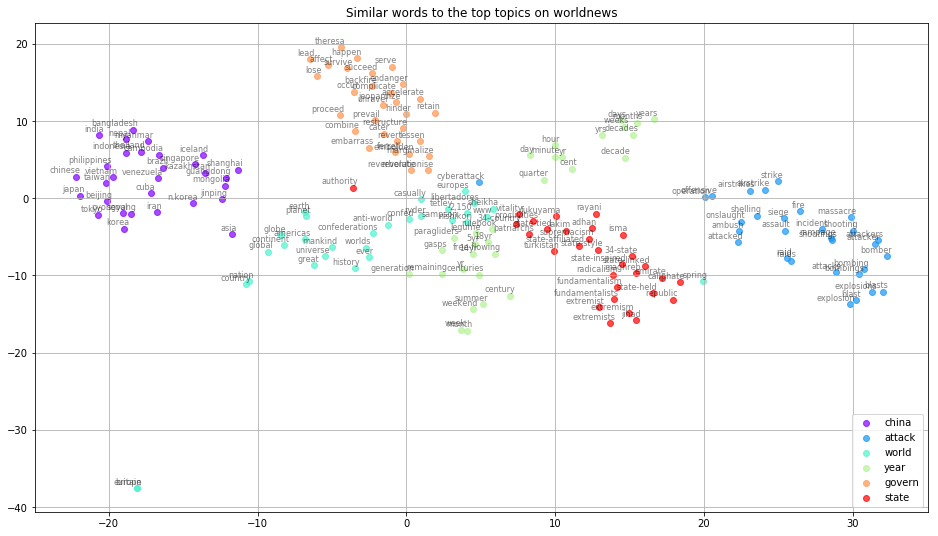

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words to the top topics on worldnews', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

## Use the embeddings to predict sentiment now
Split the data into training/validation and testing data
Train the data with sentimental values using LSTM or GRU
Predict the sentiment on testing data

Find sentiment value of each title and save it

In [34]:
title_list = worldnews['title']#topic_counts.sort_values(ascending=False)#.head(1000)
sentiment = [sid.polarity_scores(t)['compound'] for t in title_list]

In [35]:
sentiment = np.asarray(sentiment)
sentiment_val = ["" for x in range(sentiment.size)]

for i in range(sentiment.size):
    if (sentiment[i] >= 0):
        sentiment[i] = 1 #positive
        sentiment_val[i] = "positive"
    else:
        sentiment[i] = 0 #negative
        sentiment_val[i] = "negative"
    #else:
    #    sentiment[i] = 'neutral'

worldnews['sentiment'] = sentiment
worldnews['sentiment_value'] = sentiment_val

In [36]:
worldnews.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,tokenized_title,stemmed_title,pos_title,topics,sentiment,sentiment_value
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,"[scores, killed, in, pakistan, clashes]","[score, kill, in, pakistan, clash]","[NNS, VBN, IN, NN, NNS]","[score, pakistan, clash]",0.0,negative
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,"[japan, resumes, refuelling, mission]","[japan, resum, refuel, mission]","[NN, VBZ, VBG, NN]","[japan, mission]",1.0,positive
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,"[us, presses, egypt, on, gaza, border]","[us, press, egypt, on, gaza, border]","[PRP, VBZ, NN, IN, NN, NN]","[egypt, gaza, border]",1.0,positive
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,"[jump-start, economy, :, give, health, care, t...","[jump-start, economi, :, give, health, care, t...","[JJ, NN, :, JJ, NN, NN, TO, DT]","[economi, health, care]",1.0,positive
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,"[council, of, europe, bashes, eu, &, un, terro...","[council, of, europ, bash, eu, &, un, terror, ...","[NN, IN, NN, NNS, VBP, CC, JJ, NN, NN]","[council, europ, bash, terror, blacklist]",0.0,negative


## Load the pre-trained embeddings

I have already trained word2vec model and the word embeddings are saved in embedding_word2vec.txt

In [37]:
import os

embeddings_index = {}
f = open(os.path.join('','embedding_word2vec.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [39]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(worldnews['tokenized_title'])
sequences = tokenizer_obj.texts_to_sequences(worldnews['tokenized_title'])
word_index = tokenizer_obj.word_index

#pad sequences
max_length = max([len(t.split()) for t in worldnews['title']])
title_pad = pad_sequences(sequences, maxlen = max_length)

print("Shape of title tensor",title_pad.shape)
print("Shape of sentiment tensor",worldnews['sentiment'].shape)

Shape of title tensor (509236, 64)
Shape of sentiment tensor (509236,)


Map embeddings from the loaded word2vec model for each word to the *tokenizer_obj.word_index* vocabulary and create a matrix with of word vectors

In [40]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Build the model

Text -> Embedding -> LSTM (Deep Network) -> Dense (Fully Connected Layer) -> ReLU, softmax (Output Layer)

The neural network model will use the embedding layer as the first hidden layer. I can use the trained embedding vector directly in the embedding layer.

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

#define model
model = Sequential()
embedding_layer = Embedding(num_words,
                           EMBEDDING_DIM,
                           embeddings_initializer=Constant(embedding_matrix),
                           input_length=max_length,
                           trainable=False)
model.add(embedding_layer)
model.add(GRU(units=100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Using TensorFlow backend.


Split the data into training and testing data
Split the training data into training and validation data

In [42]:
#TESTING DATA
TEST_SPLIT = 0.2
indices = np.arange(title_pad.shape[0])
#np.random.shuffle(indices)
sentiment = worldnews['sentiment'][indices]

t = int(TEST_SPLIT*title_pad.shape[0])

X_train = title_pad[:-t]
y_train = sentiment[:-t]
X_test = title_pad[-t:]
y_test = sentiment[-t:]

#VALIDATION DATA
VALIDATION_SPLIT = 0.2
index = np.arange(X_train.shape[0])
np.random.shuffle(index)
sentiment = y_train[index]

nv = int(VALIDATION_SPLIT*X_train.shape[0])

X_train_pad = X_train[:-nv]
y_train_valid = sentiment[:-nv]
X_valid_pad = X_train[-nv:]
y_valid = sentiment[-nv:]

In [43]:
model.fit(X_train_pad, y_train_valid, batch_size=500, epochs=5, validation_data=(X_valid_pad, y_valid), verbose=2)

Train on 325912 samples, validate on 81477 samples
Epoch 1/5
 - 59s - loss: 0.6989 - accuracy: 0.5120 - val_loss: 0.6935 - val_accuracy: 0.5165
Epoch 2/5
 - 57s - loss: 0.6927 - accuracy: 0.5220 - val_loss: 0.6925 - val_accuracy: 0.5241
Epoch 3/5
 - 57s - loss: 0.6914 - accuracy: 0.5273 - val_loss: 0.6922 - val_accuracy: 0.5242
Epoch 4/5
 - 57s - loss: 0.6910 - accuracy: 0.5280 - val_loss: 0.6925 - val_accuracy: 0.5230
Epoch 5/5
 - 57s - loss: 0.6920 - accuracy: 0.5288 - val_loss: 0.6923 - val_accuracy: 0.5239


In [44]:
score, accu= model.evaluate(X_test, y_test, batch_size=32)
print(accu*100)

101847/101847 [==============================] - 57s 558us/step
51.924943923950195


## Analysis:

Accuracy of my model ~50% which is low and it can be better. One of the reasons:
* Self labelled dataset for sentiment using nltk vader
* Currently no way to tell if the testing dataset or training has correct values
* Ran for 10 epochs and the values still did not converge, maybe need to run more epochs

Further exploration:
* Figure out a way to label the data
* Use a pre-trained BERT to predict the sentiment value

## TRAIN THE MODEL TO PREDICT POPULARITY

Use the upvotes to classify the popularity of the post and label it 
* if upvotes >= 100 : 1 (popular)
* else: 0 (not popular)

In [46]:
up_votes = worldnews['up_votes']
upvote = np.zeros(up_votes.size)
upvote_val = ["" for x in range(up_votes.size)]

for i in range(up_votes.size):
    if (up_votes[i] >= 100):
        upvote[i] = 1
        upvote_val[i] = "popular"
    else:
        upvote[i] = 0
        upvote_val[i] = "not popular"

worldnews['popularity'] = upvote
worldnews['popularity_value'] = upvote_val

In [47]:
worldnews.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,tokenized_title,stemmed_title,pos_title,topics,sentiment,sentiment_value,popularity,popularity_value
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,"[scores, killed, in, pakistan, clashes]","[score, kill, in, pakistan, clash]","[NNS, VBN, IN, NN, NNS]","[score, pakistan, clash]",0.0,negative,0.0,not popular
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,"[japan, resumes, refuelling, mission]","[japan, resum, refuel, mission]","[NN, VBZ, VBG, NN]","[japan, mission]",1.0,positive,0.0,not popular
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,"[us, presses, egypt, on, gaza, border]","[us, press, egypt, on, gaza, border]","[PRP, VBZ, NN, IN, NN, NN]","[egypt, gaza, border]",1.0,positive,0.0,not popular
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,"[jump-start, economy, :, give, health, care, t...","[jump-start, economi, :, give, health, care, t...","[JJ, NN, :, JJ, NN, NN, TO, DT]","[economi, health, care]",1.0,positive,0.0,not popular
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,"[council, of, europe, bashes, eu, &, un, terro...","[council, of, europ, bash, eu, &, un, terror, ...","[NN, IN, NN, NNS, VBP, CC, JJ, NN, NN]","[council, europ, bash, terror, blacklist]",0.0,negative,0.0,not popular


In [48]:
#TESTING DATA
TEST_SPLIT = 0.2
indices = np.arange(title_pad.shape[0])
#np.random.shuffle(indices)
popularity = worldnews['popularity'][indices]

t = int(TEST_SPLIT*title_pad.shape[0])

X_train = title_pad[:-t]
y_train = popularity[:-t]
X_test = title_pad[-t:]
y_test = popularity[-t:]

#VALIDATION DATA
VALIDATION_SPLIT = 0.2
index = np.arange(X_train.shape[0])
np.random.shuffle(index)
sentiment = y_train[index]

nv = int(VALIDATION_SPLIT*X_train.shape[0])

X_train_pad = X_train[:-nv]
y_train_valid = sentiment[:-nv]
X_valid_pad = X_train[-nv:]
y_valid = sentiment[-nv:]

In [50]:
model.fit(X_train_pad, y_train_valid, batch_size=1000, epochs=5, validation_data=(X_valid_pad, y_valid), verbose=1, shuffle=True)

Train on 325912 samples, validate on 81477 samples
Epoch 1/5
325912/325912 [==============================] - 28s 86us/step - loss: 0.3290 - accuracy: 0.9045 - val_loss: 0.3183 - val_accuracy: 0.9043
Epoch 2/5
325912/325912 [==============================] - 29s 90us/step - loss: 0.3148 - accuracy: 0.9054 - val_loss: 0.3174 - val_accuracy: 0.9043
Epoch 3/5
325912/325912 [==============================] - 28s 86us/step - loss: 0.3139 - accuracy: 0.9054 - val_loss: 0.3162 - val_accuracy: 0.9043
Epoch 4/5
325912/325912 [==============================] - 29s 89us/step - loss: 0.3140 - accuracy: 0.9054 - val_loss: 0.3165 - val_accuracy: 0.9043
Epoch 5/5
325912/325912 [==============================] - 28s 85us/step - loss: 0.3135 - accuracy: 0.9054 - val_loss: 0.3160 - val_accuracy: 0.9043


In [51]:
score, accu= model.evaluate(X_test, y_test, batch_size=32)
print(accu*100)

101847/101847 [==============================] - 55s 544us/step
88.43952417373657


## Analysis:

* Accuracy of my model ~88% on the test dataset. The model classifies a title is popular or not popular pretty accurately.
* The accuracy can be improved with a smaller batch_size and more epochs
* The down_votes in the dataset are 0 for all the titles which is not realistically possible
* Either the up_votes are a sum of actual up_votes and down_votes or the data is missing down_votes value
* This could change the popularity of the posts